In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import numpy as np
from tensorflow.keras import utils
import sys, os
import seaborn as sns
import pandas as pd
from sklearn import metrics
try:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
except:
    pass
print(tf.__version__)
import matplotlib.pyplot as plt
%matplotlib inline

2.2.0-rc2


In [0]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# set numeric type to float32 from unit8
x_train_raw = x_train.astype("float32")
x_test_raw = x_test.astype("float32")

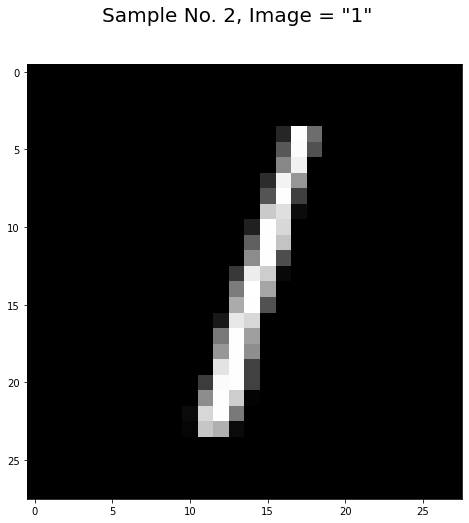

In [0]:
# pick a sample to plot
sample = 2
image = x_test_raw[sample]# plot the sample
fig = plt.figure(figsize=(8,8))
fig.suptitle('Sample No. 2, Image = "1"', fontsize=20)
plt.imshow(image, cmap='gray')
plt.show()

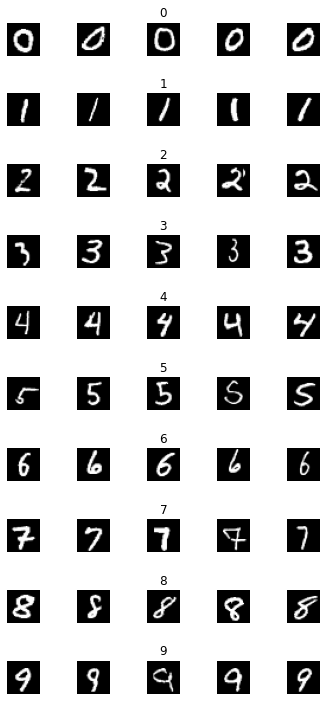

In [0]:
num_of_samples = []

cols = 5 #We will select 5 random images
num_of_classes = 10 #each digit total: 10

fig, axs = plt.subplots(nrows=num_of_classes, ncols=cols,
                       figsize=(5, 10))
fig.tight_layout()
for i in range(cols):
  for j in range(num_of_classes):
    x_selected = x_train[y_train == j]
    axs[j][i].imshow(x_selected[np.random.randint(0, len(x_selected -1)),
                                :, :],
                    cmap=plt.get_cmap('gray')) 
    axs[j][i].axis("off")
    if i==2:
      axs[j][i].set_title(str(j))
      num_of_samples.append(len(x_selected))

In [0]:
x_train, x_test = x_train_raw / 255.0, x_test_raw / 255.0

# Transform lables to one-hot encoding
y_train = utils.to_categorical(y_train, 10)
y_test = utils.to_categorical(y_test, 10)

# Reshape the dataset into 4D array
x_train = x_train.reshape(x_train.shape[0], 28,28,1)
x_test = x_test.reshape(x_test.shape[0], 28,28,1) 

In [0]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [0]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPU


In [0]:
start = time.time()
with tf.device('/CPU:0'):
  a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
  b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
end = time.time()

c = tf.matmul(a, b)
print(c)

print ("Model took "+str((end - start)/60)+" minutes to work on CPU")

tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)
Model took 7.589658101399739e-06 minutes to work on CPU


In [0]:
start = time.time()
with tf.device('/GPU:0'):
  a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
  b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
end = time.time()

c = tf.matmul(a, b)
print(c)

print ("Model took "+str((end - start)/60)+" minutes to work on GPU")

tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)
Model took 3.874301910400391e-06 minutes to work on GPU


In [0]:
#Instantiate an empty model
model = tf.keras.models.Sequential()

# C1 Convolutional Layer
model.add(tf.keras.layers.Conv2D(6, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=(28,28,1), padding="same"))

# S2 Pooling Layer
# model.add(tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))

model.add(tf.keras.layers.Dropout(0.3))

# C3 Convolutional Layer
model.add(tf.keras.layers.Conv2D(16, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='valid'))

# S4 Pooling Layer
# model.add(tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))

model.add(tf.keras.layers.Dropout(0.3))

# C5 Fully Connected Convolutional Layer
model.add(tf.keras.layers.Conv2D(120, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='valid'))
#Flatten the CNN output so that we can connect it with fully connected layers
model.add(tf.keras.layers.Flatten())

# FC6 Fully Connected Layer
model.add(tf.keras.layers.Dense(84, activation='relu'))

#Output Layer with softmax activation
model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [0]:
import functools
top3_acc = functools.partial(tf.keras.metrics.top_k_categorical_accuracy, k=3)

top3_acc.__name__ = 'top3_acc'

with tf.device('/device:GPU:0'):
  # Compile the model
  # model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer='Adam', metrics=["accuracy"]) 
  model.compile(tf.keras.optimizers.Adam(lr=.001),#
    # tf.keras.optimizers.RMSprop(lr=2e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy','top_k_categorical_accuracy',top3_acc])

hist = model.fit(x=x_train,y=y_train, epochs=20, batch_size=128, validation_data=(x_test, y_test), verbose=1) 

Epoch 1/20
469/469 [==============================] - 5s 12ms/step - loss: 0.0068 - accuracy: 0.9977 - top_k_categorical_accuracy: 1.0000 - top3_acc: 1.0000 - val_loss: 0.0451 - val_accuracy: 0.9884 - val_top_k_categorical_accuracy: 0.9999 - val_top3_acc: 0.9991
Epoch 2/20
469/469 [==============================] - 5s 12ms/step - loss: 0.0067 - accuracy: 0.9976 - top_k_categorical_accuracy: 1.0000 - top3_acc: 1.0000 - val_loss: 0.0361 - val_accuracy: 0.9906 - val_top_k_categorical_accuracy: 1.0000 - val_top3_acc: 0.9996
Epoch 3/20
469/469 [==============================] - 5s 11ms/step - loss: 0.0062 - accuracy: 0.9979 - top_k_categorical_accuracy: 1.0000 - top3_acc: 1.0000 - val_loss: 0.0388 - val_accuracy: 0.9906 - val_top_k_categorical_accuracy: 1.0000 - val_top3_acc: 0.9994
Epoch 4/20
469/469 [==============================] - 5s 11ms/step - loss: 0.0057 - accuracy: 0.9980 - top_k_categorical_accuracy: 1.0000 - top3_acc: 1.0000 - val_loss: 0.0371 - val_accuracy: 0.9903 - val_top_k_

In [0]:
train_score = model.evaluate(x_train, y_train)
test_score = model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0423 - accuracy: 0.9905 - top_k_categorical_accuracy: 0.9999 - top3_acc: 0.9993


In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 6)         60        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 27, 6)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 27, 27, 6)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 25, 25, 16)        880       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 22, 22, 120)      

In [0]:
print("Train loss {:.4f}, accuracy {:.2f}%".format(train_score[0], train_score[1] * 100)) 
print("Test loss {:.4f}, accuracy {:.2f}%".format(test_score[0], test_score[1] * 100)) 

Train loss 0.0040, accuracy 99.88%
Test loss 0.0420, accuracy 98.87%


In [0]:
y_pred = model.predict(x_test)

1


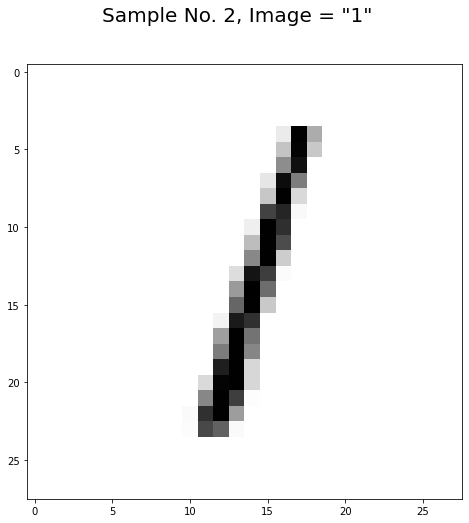

In [0]:
image_index = 2
fig = plt.figure(figsize=(8,8))
fig.suptitle('Sample No. 2, Image = "1"', fontsize=20)
plt.imshow(x_test[image_index].reshape(28, 28),cmap='Greys')
pred = model.predict(x_test[image_index].reshape(1, 28, 28, 1))
print(pred.argmax())

In [0]:
class_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

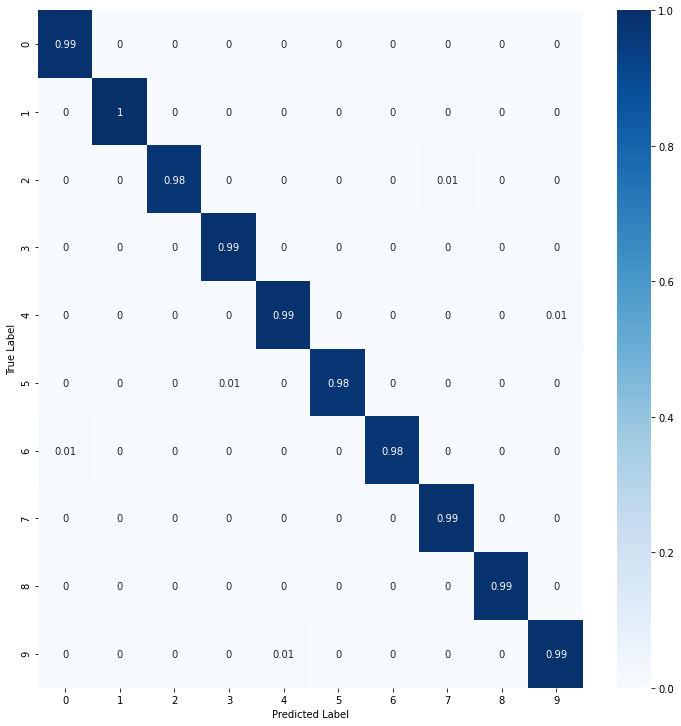

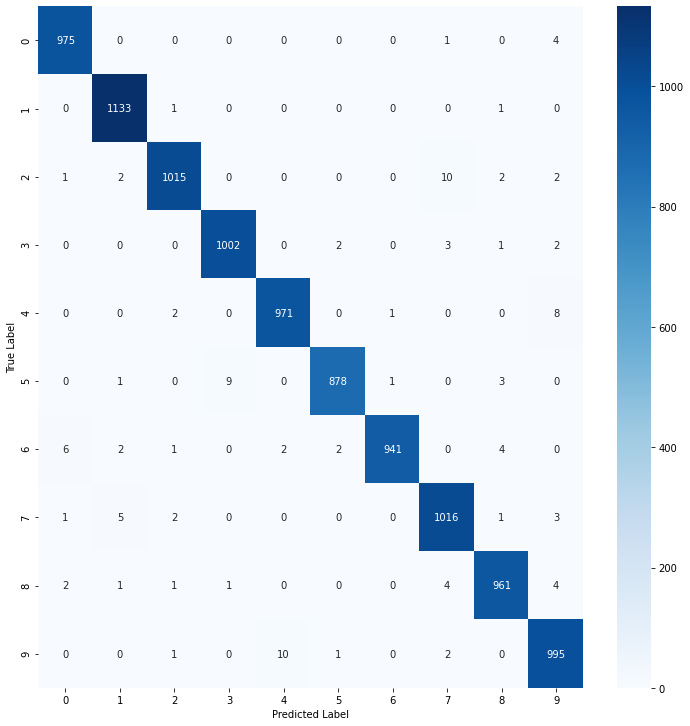

In [0]:
# y_test.shape
y_pred.shape
confusion_matrix = tf.math.confusion_matrix(labels=tf.argmax(y_test,1), predictions=tf.argmax(y_pred,1)).numpy()
confusion_mat_norm = np.around(confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:,np.newaxis], decimals=2)

confusion_mat_df = pd.DataFrame(confusion_mat_norm, index=class_names, columns = class_names)
figure = plt.figure(figsize=(10, 10))
sns.heatmap(confusion_mat_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()# y_test.shape
y_pred.shape
confusion_matrix = tf.math.confusion_matrix(labels=tf.argmax(y_test,1), predictions=tf.argmax(y_pred,1)).numpy()
confusion_mat_df = pd.DataFrame(confusion_matrix, index=class_names, columns = class_names)
figure = plt.figure(figsize=(10, 10))
sns.heatmap(confusion_mat_df, annot=True, fmt="d", cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

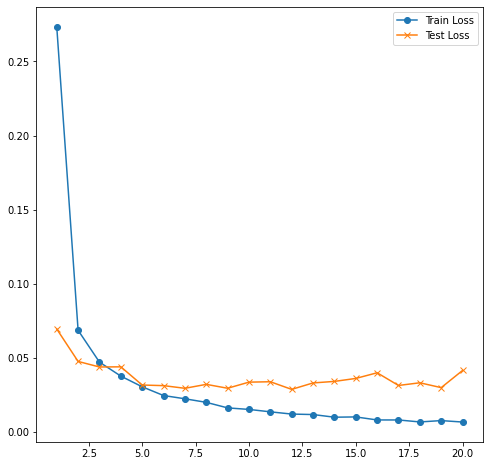

In [0]:
# Plot the graph
f, ax = plt.subplots(figsize=(8,8))
ax.plot([None] + hist.history['loss'], 'o-')
ax.plot([None] + hist.history['val_loss'], 'x-')
# Plot legend and use the best location automatically: loc = 0.
ax.legend(['Train Loss', 'Test Loss'], loc = 0)
# plt.plot()
plt.show()

In [0]:
# probs = model.predict_proba(x_test)
# best_n = np.argsort(probs, axis=1)[:,-5:]
# print(probs)
# print(best_n)
top1 = 0.0
top5 = 0.0    
class_probs = model.predict(x_test)
for i, l in enumerate(x_test):
    class_prob = class_probs[i]
    top_values = (-class_prob).argsort()[:5]
    if top_values[0] == l.any():
        top1 += 1.0
    if np.isin(np.array([l]).any(), top_values):
        top5 += 1.0

print("top1 acc", top1/len(x_test))
print("top5 acc", top5/len(x_test))

top1 acc 0.1144
top5 acc 0.4551
